In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
#Gradient and Hessian of elastic energies

In [48]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

In [49]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [50]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [51]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [52]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

In [53]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [54]:
def getFb(q, EI, deltaL):
  # q - DOF vector of size N
  # EI - bending stiffness
  # deltaL - undeformed Voronoi length (assume to be a scalar for this simple example)
  # Output:
  # Fb - a vector (negative gradient of elastic stretching force)
  # Jb - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fb = np.zeros(ndof) # bending force
  Jb = np.zeros((ndof, ndof))

  # First bending spring (USE A LOOP for the general case)
  for k in range(1, N-1):
    xkm1 = q[2*k-2] # x coordinate of the first node
    ykm1 = q[2*k-1] # y coordinate of the first node
    xk = q[2*k] # x coordinate of the second node
    yk = q[2*k+1] # y coordinate of the second node
    xkp1 = q[2*k+2] # x coordinate of the third node
    ykp1 = q[2*k+3] # y coordinate of the third node
    ind = np.arange(2*k-2, 2*k+4)
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    Fb[ind] -= gradEnergy # force = - gradient of energy. Fb is the stretching force
    Jb[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:6

  return Fb, Jb

In [55]:
# Problem data
L_beam = 1.0                      # total beam length [m]
R_out  = 0.013                    # outer radius [m]
r_in   = 0.011                    # inner radius [m]
E      = 70e9                     # Young's modulus for aluminum [Pa]
rho    = 2700.0                   # density [kg/m^3]
I      = np.pi/4.0*(R_out**4 - r_in**4)  # 2nd moment [m^4]
A      = np.pi*(R_out**2 - r_in**2)      # cross-sectional area [m^2]

# Discretization / time stepping
N      = 50                       # number of nodes
ndof   = 2*N
dt     = 1e-2                     # [s]
t_end  = 1.0                      # [s]
nsteps = int(np.round(t_end/dt))
deltaL = L_beam/(N-1)

In [56]:
# Reference straight configuration
x_ref = np.linspace(0.0, L_beam, N)
y_ref = np.zeros(N)
q_ref = np.zeros(ndof)
q_ref[0::2] = x_ref
q_ref[1::2] = y_ref

In [57]:
# Initial conditions
q0 = q_ref.copy()
u0 = np.zeros_like(q0)

In [58]:
# Lumped mass matrix
m_node = A * L_beam * rho / (N-1)
mvec   = np.zeros(ndof)
mvec[0::2] = m_node
mvec[1::2] = m_node
M = np.diag(mvec)

In [59]:
# Effective stiffness scales
EI_val = E * I
EA_val = E * A

In [60]:
# Boundary conditions (simply-supported HW2):
#  - Node 0: x and y fixed
#  - Node N-1: y fixed only (x free)
fixed_dofs = np.array([0, 1, 2*(N-1)+1], dtype=int)
all_dofs   = np.arange(ndof, dtype=int)
free_dofs  = np.setdiff1d(all_dofs, fixed_dofs)

# External point load: downward P at node nearest x=0.75 m
def make_load(P):
    idx = int(np.argmin(np.abs(x_ref - 0.75)))
    W = np.zeros(ndof)
    W[2*idx+1] = -P  # negative y direction
    return W

In [61]:
# Small-deflection Euler–Bernoulli prediction for max deflection
def beam_theory_ymax(P, l=L_beam, d=0.75, E=E, I=I):
    c = min(d, l-d)
    y_mag = (P * c * (l*l - c*c)**1.5) / (9.0*np.sqrt(3.0)*E*I*l)
    return -y_mag


In [62]:
# Time integrator (Backward Euler / Newton)
def implicit_step(q_old, u_old, dt, EI, EA, W, tol=1e-6, maxit=80):
    """
    Single Backward Euler step for q_new.
    This matches the Newton residual style from lecture:
    f = inertia - elastic - external = 0
    J = d(f)/d(q_new)
    We solve only on free DOFs each Newton iteration.
    """
    q_new = q_old.copy()

    for it in range(maxit):
        # inertia term
        F_in = mvec/dt * ((q_new - q_old)/dt - u_old)   # shape (2N,)
        J_in = M / (dt*dt)                              # shape (2N,2N)

        # elastic internal force and stiffness
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL)
        F_el = Fs + Fb
        J_el = Js + Jb

        # residual and Jacobian
        f_full = F_in - F_el - W
        J_full = J_in - J_el

        # solve only for free DOFs
        f_free = f_full[free_dofs]
        J_free = J_full[np.ix_(free_dofs, free_dofs)]

        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_dofs] -= dq_free

        # convergence check
        if np.linalg.norm(f_free) < tol:
            return q_new, True

    return q_new, False  # if not converged, still return q_new

def simulate(P, T=t_end, dt=dt, q_seed=None):
    """
    Run simulation with constant load P for time [0, T].
    Returns:
      q_final   : final positions (2N,)
      yhist     : y_max(t) (array length steps+1)
      q_history : list of q at each step (including t=0 and final)
    """
    steps = int(round(T/dt))
    q = q_seed.copy() if q_seed is not None else q0.copy()
    u = np.zeros_like(q)
    W = make_load(P)

    yhist = np.zeros(steps+1)
    q_history = [q.copy()]

    y_all = q[1::2]
    yhist[0] = np.min(y_all)  # most negative = max downward

    for n in range(1, steps+1):
        q_new, ok = implicit_step(q, u, dt, EI=EI_val, EA=EA_val, W=W,
                                  tol=1e-6, maxit=60)
        if not ok:
            print(f"[warn] Newton did not fully converge at step {n}")

        u_new = (q_new - q)/dt
        q, u = q_new, u_new

        q_history.append(q.copy())

        y_all = q[1::2]
        yhist[n] = np.min(y_all)

    return q, yhist, q_history



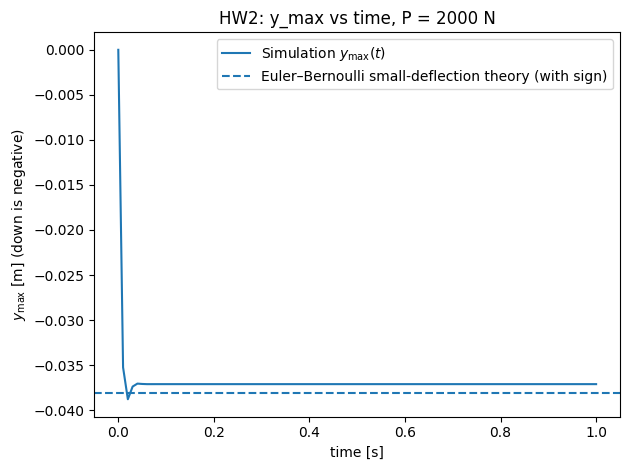

Final simulated y_max at t=1.00s: -3.710929e-02 m
Small-deflection beam theory y_max:    -3.804492e-02 m


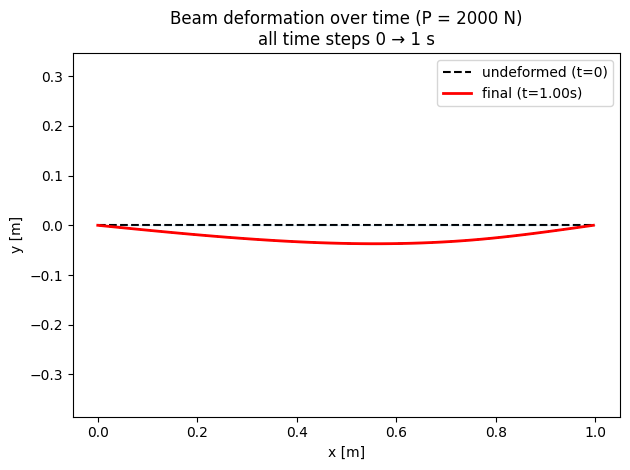

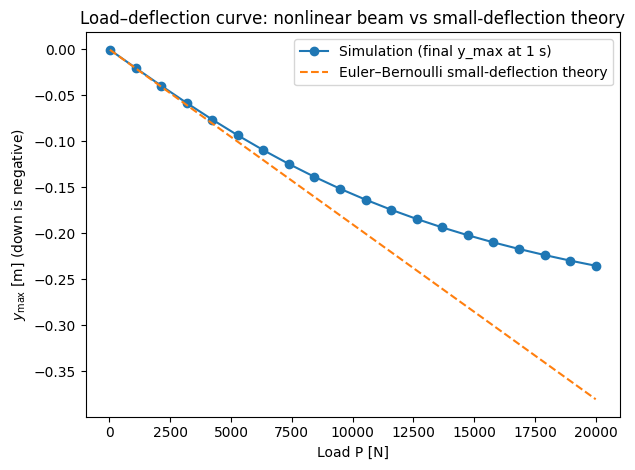

~5% deviation starts around P ≈ 4226 N


In [45]:
#Time evolution of y_max(t) at P = 2000 N, and compare with theory
P_single = 2000.0
q_final_2000, yhist_2000, q_hist_2000 = simulate(P_single, T=t_end, dt=dt)

t_arr = np.linspace(0.0, t_end, yhist_2000.size)
y_theory_2000 = beam_theory_ymax(P_single)  # now negative

plt.figure()
plt.plot(t_arr, yhist_2000, label=r"Simulation $y_{\max}(t)$")
plt.axhline(y_theory_2000, linestyle='--',
            label="Euler–Bernoulli small-deflection theory (with sign)")
plt.xlabel("time [s]")
plt.ylabel(r"$y_{\max}$ [m] (down is negative)")
plt.title("HW2: y_max vs time, P = 2000 N")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final simulated y_max at t={t_end:.2f}s: {yhist_2000[-1]:.6e} m")
print(f"Small-deflection beam theory y_max:    {y_theory_2000:.6e} m")

# Deformation history plot:
# -dashed black: undeformed (t=0)
# - faint lines: intermediate steps at each time in [0, t_end]
# - bold line: final configuration
plt.figure()

# undeformed
plt.plot(x_ref, y_ref, 'k--', linewidth=1.5, label="undeformed (t=0)")

# all intermediate steps
for q_t in q_hist_2000[:-1]:
    x_t = q_t[0::2]
    y_t = q_t[1::2]
    plt.plot(x_t, y_t, alpha=0.15, linewidth=0.8)

# final shape
x_final = q_final_2000[0::2]
y_final = q_final_2000[1::2]
plt.plot(x_final, y_final, 'r-', linewidth=2.0, label=f"final (t={t_end:.2f}s)")

plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Beam deformation over time (P = 2000 N)\nall time steps 0 → 1 s")
plt.legend()
plt.tight_layout()
plt.show()

# Load–deflection curve and theory vs simulation
Ps = np.linspace(20.0, 20000.0, 20)
sim_last = []
th_last  = []
q_seed = None

for P in Ps:
    q_seed, yhistP, _ = simulate(P, T=t_end, dt=dt, q_seed=q_seed)
    sim_last.append(yhistP[-1])         # final y_max from simulation (negative)
    th_last.append(beam_theory_ymax(P)) # theory (also negative now)

Ps = np.array(Ps)
sim_last = np.array(sim_last)
th_last  = np.array(th_last)

plt.figure()
plt.plot(Ps, sim_last, 'o-', label="Simulation (final y_max at 1 s)")
plt.plot(Ps, th_last,  '--', label="Euler–Bernoulli small-deflection theory")
plt.xlabel("Load P [N]")
plt.ylabel(r"$y_{\max}$ [m] (down is negative)")
plt.title("Load–deflection curve: nonlinear beam vs small-deflection theory")
plt.legend()
plt.tight_layout()
plt.show()

# Estimate when large-deformation effects kick in (>5% difference)
rel_err = np.where(np.abs(th_last) > 1e-16,
                   np.abs(sim_last - th_last)/np.abs(th_last),
                   np.inf)
over5 = np.where(rel_err > 0.05)[0]
if over5.size > 0:
    print(f"~5% deviation starts around P ≈ {Ps[over5[0]]:.0f} N")
else:
    print("No >5% deviation in 20–20000 N; try bigger P if you want stronger nonlinearity.")
